In [1]:
# IMPORT ------
    #* Dataframe 
import pandas as pd 
    #* Matrices 
import numpy as np
    #* Preprocessing 
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
    #* Splitter 
from sklearn.model_selection import train_test_split

#* Gradient boosting 
from catboost import Pool, CatBoostRegressor

    # Misc
import os 

In [2]:
# PATH ------
base_path = "/home/jovyan/work"  #"/Maturite_dentaire"
data_path = "data/Teeth"
data_name= "dataset.csv"

# CWD ------
os.chdir(base_path)

# IMPORT TYPES ------
pandas_types= {'ID':'int','VAL_I1':'category','VAL_I2':'category',
            'VAL_C1':'category','VAL_PM1':'category',
            'VAL_PM2':'category','VAL_M1':'category',
            'VAL_M2':'category','VAL_M3':'category'}

# ORDINAL ENCODING ------
ord_encoding= {'A':2,'B':3,'C':4,'D':5,'E':6,'F':7,'G':8,'H':9}

# RANDOM STATE ------
rs= 123

# PREPROCESSING 

## IMPORT DATA 

In [3]:
# IMPORT DATA ------
df = pd.read_csv(os.path.join(data_path,data_name),
                 sep=';',
                 dtype=pandas_types)

# Remove useless columns ---
X = df.drop(['ID', 'PAT_AGE'], axis=1)
Y = df['PAT_AGE']

# Train test split 

In [4]:
X_train,X_test, y_train, y_test = train_test_split(X,Y, random_state= rs,train_size=0.8)  

In [5]:
print(f"Shape Training Data : {X_train.shape}")
print(f"Shape Testing Data : {X_test.shape}")

print(f"Shape Training Target : {y_train.shape}")
print(f"Shape Testing Target : {y_test.shape}")

Shape Training Data : (2277, 9)
Shape Testing Data : (570, 9)
Shape Training Target : (2277,)
Shape Testing Target : (570,)


In [6]:
# Save to csv ---
X_train.to_csv(os.path.join(data_path,"X_train.csv"), index=False)
y_train.to_csv(os.path.join(data_path,"y_train.csv"), index=False)

X_test.to_csv(os.path.join(data_path,"X_test.csv"), index=False)
y_test.to_csv(os.path.join(data_path,"y_test.csv"), index=False)

## Ordinal encoding 

In [7]:
# Simple Ordinal Encoding ---
X_train.replace(ord_encoding, inplace=True)
X_test.replace(ord_encoding, inplace=True)

# Saving Ordinal encoded data --- 
X_train.to_csv(os.path.join(data_path,"1_X_train_encoded.csv"),index=False)
X_test.to_csv(os.path.join(data_path,"1_X_test_encoded.csv"),index=False)

## Removing outliers 

In [8]:
# Remove all samples for which at least 8 out of 8 teeth info is missing --- 
to_rm = np.where(np.sum(pd.isna(X_train),axis=1)>=8)[0] # rowsums : looking for >= 7
X_train = X_train.reset_index(drop=True).drop(to_rm,axis=0) # remove rows from training 
y_train = y_train.reset_index(drop=True).drop(to_rm,axis=0) # remove rows from labels 

# reset indexes --- 
X_train.reset_index(drop= True, inplace=True)
y_train.reset_index(drop= True, inplace=True)

# Printing n° of rows removed : 
print(f"Number of samples removed from trainin data : {to_rm.shape}")

Number of samples removed from trainin data : (115,)


# TRAIN VAL TEST SPLIT 

- Training 
- Validation 
- Testing

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, random_state= rs,test_size=0.1)


In [10]:
print(f"Shape Training Data : {X_train.shape}")
print(f"Shape Training Target : {y_train.shape}")
print("\n")
print(f"Shape Validation Target : {X_val.shape}")
print(f"Shape Validation Data : {y_val.shape}")
print("\n")
print(f"Shape Testing Data : {X_test.shape}")
print(f"Shape Testing Target : {y_test.shape}")

Shape Training Data : (1945, 9)
Shape Training Target : (1945,)


Shape Validation Target : (217, 9)
Shape Validation Data : (217,)


Shape Testing Data : (570, 9)
Shape Testing Target : (570,)


## Imputing 

In [11]:
# IMPUTING STRATEGY ------
knni= KNNImputer(n_neighbors= 40,weights= "distance",add_indicator= True)
X_train= knni.fit_transform(X_train.values) 
X_val= knni.transform(X_val.values) 
X_test= knni.transform(X_test.values) 

# New columns --- 
indicator_features= []
for i in X.columns.values[1:]:
    indicator_features.append(i+ "_missing_indicator")
new_cols= [*list(X.columns), *indicator_features]

# Saving Ordinal encoded data --- 
pd.DataFrame(X_train,columns= new_cols).to_csv(os.path.join(data_path,"2_X_train_encoded.csv"),index=False)
pd.DataFrame(X_val,columns= new_cols).to_csv(os.path.join(data_path,"2_X_val_encoded.csv"),index=False)
pd.DataFrame(X_test, columns= new_cols).to_csv(os.path.join(data_path,"2_X_test_encoded.csv"),index=False)

## Outlier removal 

In [12]:
# isolation forest 
#train ---
Y_pred_train = IsolationForest(random_state=rs,bootstrap=True,contamination=0.05).fit_predict(X_train) # fit outlier detection # Returns -1 for outliers and 1 for inliers.
inliers = np.where(Y_pred_train == 1)[0] # which samples to keep 
    #* Keep non outliers
X_train = X_train[inliers,:]
y_train = y_train.reset_index(drop=True)[inliers]

In [13]:
print(f"Shape Training Data : {X_train.shape}")
print(f"Shape Training Labels Data : {y_train.shape}")

Shape Training Data : (1847, 17)
Shape Training Labels Data : (1847,)


In [14]:
# Saving preprocesssed data --- 
    #* Train 
pd.DataFrame(X_train,columns= new_cols).to_csv(os.path.join(data_path,"3_X_train_outlier.csv"),index=False)
pd.Series(y_train,name="Age").to_csv(os.path.join(data_path,"3_y_train_outlier.csv"),index=False)
    #* val 
pd.DataFrame(X_val,columns= new_cols).to_csv(os.path.join(data_path,"3_X_val_outlier.csv"),index=False)
pd.Series(y_val,name="Age").to_csv(os.path.join(data_path,"3_y_val_outlier.csv"),index=False)
    #* Train 
pd.DataFrame(X_test,columns= new_cols).to_csv(os.path.join(data_path,"3_X_test_outlier.csv"),index=False)
pd.Series(y_test,name="Age").to_csv(os.path.join(data_path,"3_y_test_outlier.csv"),index=False)

In [15]:
model = CatBoostRegressor(iterations=16000, # by model.best_iteration_ 
                          depth=3, 
                          learning_rate=0.001, 
                          loss_function='MAE',
                          train_dir = "mae",
                          random_seed=rs,
                          grow_policy= "SymmetricTree",
                          l2_leaf_reg= 600,
                          use_best_model=True,
                          od_type="Iter",
                          od_wait=100,
                          verbose=0,
                          colsample_bylevel=0.9,
                         )
#train the model
model.fit(X= X_train, y= y_train,
          plot=True,
          eval_set=(X_val,y_val))
# make the prediction using the resulting model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
# Picking this iteration ---
model.best_iteration_

15795

In [17]:
np.mean(np.abs(model.predict(X_test)-y_test))

1.214607019097094

In [18]:
# Saving results to plot ---
res = {"learn":model.evals_result_["learn"]["MAE"], 
"validation": model.evals_result_["validation"]["MAE"]}

res_plot=pd.DataFrame(res)
res_plot.to_csv("evals_result_.csv", index=None)

In [19]:
model.feature_importances_

array([1.12806777e+00, 1.79036618e+00, 2.30691682e+00, 3.31798843e+00,
       8.27999744e+00, 1.05015309e+01, 3.93552485e+00, 2.47342157e+01,
       4.24086596e+01, 2.80013931e-02, 1.73578657e-02, 2.25777014e-03,
       9.80979648e-03, 7.14925227e-02, 1.25284441e-02, 9.99835233e-02,
       1.35530104e+00])

### Feature importance

In [20]:
import shap
shap_values = model.get_feature_importance(Pool(X_test, label=y_test),type="ShapValues")
shap_values = shap_values[:,:-1]

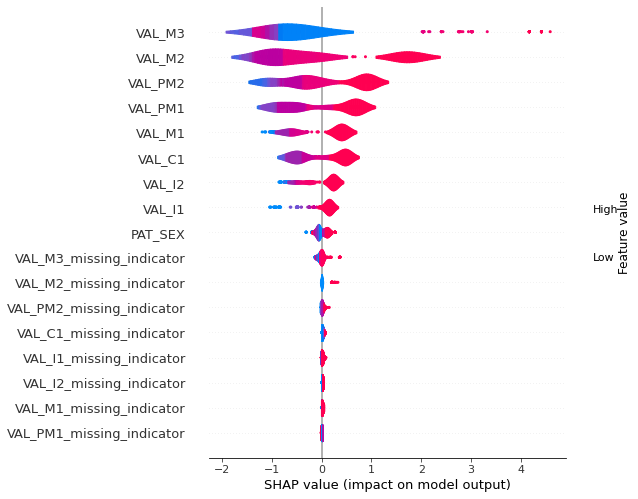

In [21]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test,feature_names=new_cols,plot_type="violin",show=False)
plt.savefig('feature_imp_shap.png',pad_inches=0.7,dpi=50,bbox_inches="tight")

In [22]:
pd.DataFrame(shap_values, columns=new_cols).to_csv("shap_vals.csv", index=None)

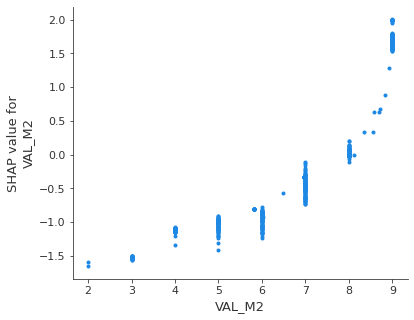

In [23]:
shap.dependence_plot("VAL_M2", shap_values, X_test, feature_names=new_cols, interaction_index = None)

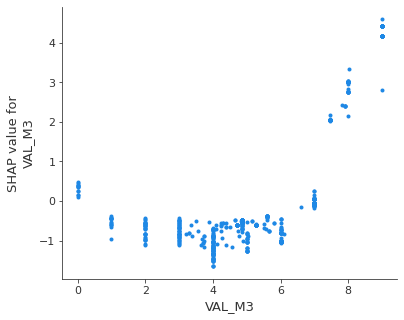

In [24]:
shap.dependence_plot("VAL_M3", shap_values, X_test, feature_names=new_cols, interaction_index = None)